In [1]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import time


#import models
from model_em import fbsde
from model_em import BSDEsolverEm   

In [ ]:
#defining our equation
dim_x, dim_y, dim_d, dim_h, num_h, N, itr, batch_size = 1, 1, 1, 24, 3, 100, 3000, 256#batch size is number of paths used in each iteration

x_0, T = torch.ones(dim_x), 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# a, b = 1
def b(t, x, y):
    return (1-x).reshape(batch_size, dim_x)


def sigma(t, x):
    return torch.sqrt(torch.abs(x)).reshape(batch_size, dim_x, dim_d)


def f(t, x, y, z):
    return (-y*x).reshape(batch_size, dim_y)


def g(x):
    return torch.ones(batch_size, dim_y,device=device)

equation = fbsde(x_0, b, sigma, f, g, T,dim_x, dim_y, dim_d)

samples = 1

#Calculates exact y0 (~0.39647)
a, b, sigma = 1, 1, 1
gamma = np.sqrt(a**2 + 2* sigma**2)
num1 = 2*gamma* np.exp((gamma + a) / 2)
denom1 = (gamma - a) + ((gamma + a) * np.exp(gamma))
num2 = 2*(1 - np.exp(gamma))
denom2 = (gamma - a) + ((gamma + a) * np.exp(gamma))
y0_exact = (num1/denom1)**2 * np.exp(num2/denom2) 
print("Exact y0: ", y0_exact)

N_list = [10,50,100]

Exact y0:  0.3964731885026399


In [ ]:
times = {}
for N in N_list:
    times[N] = []
    for i in range(samples):
        start = time.time()
        bsde_solver_em = BSDEsolverEm(equation, dim_h, num_h)
        bsde_solver_em.train(batch_size, N, itr, log=True, test_num= N + i)
        end = time.time()
        times[N].append((end - start))
    

Iteration 2999, Loss: 8.981012797448784e-05, y_0: 0.39674362540245056
Time taken for N =  300  is  278.26995277404785
Iteration 2999, Loss: 0.00010638732055667788, y_0: 0.39679408073425293
Time taken for N =  300  is  296.97336292266846
Iteration 2999, Loss: 0.00010353910329286009, y_0: 0.39677390456199646
Time taken for N =  300  is  301.7454068660736
Iteration 2999, Loss: 0.0005196620477363467, y_0: 0.3968183398246765
Time taken for N =  300  is  305.1336278915405
Iteration 2999, Loss: 0.00012784790305886418, y_0: 0.3966943919658661
Time taken for N =  300  is  298.91622591018677
Iteration 2999, Loss: 0.00016226981824729592, y_0: 0.3967662453651428
Time taken for N =  300  is  299.81922912597656
Iteration 2999, Loss: 0.00016249113832600415, y_0: 0.39668697118759155
Time taken for N =  300  is  294.4450008869171
Iteration 2999, Loss: 0.00017350861162412912, y_0: 0.39667585492134094
Time taken for N =  300  is  298.5064001083374
Iteration 2999, Loss: 0.00012371171033009887, y_0: 0.3968

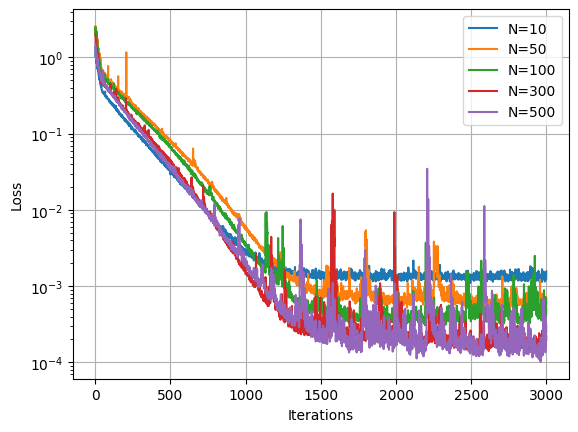

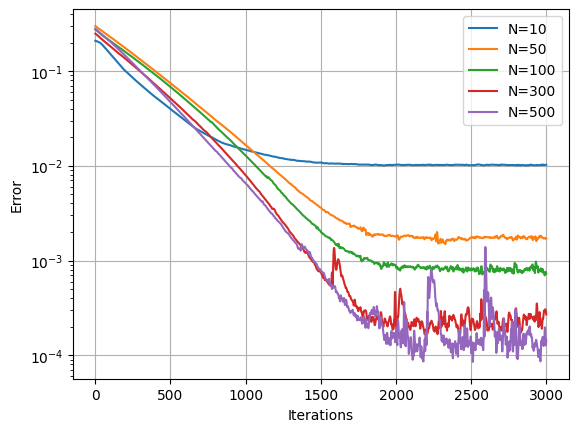

In [42]:
avg_loss = {}
avg_error = {}
plt.figure()
for N in N_list:
    avg_loss[N] = np.zeros(itr)
    for i in range(samples):
        loss_data = np.load(f'loss_data_EM{N+i}.npy')
        avg_loss[N] += loss_data/(samples)
    plt.plot(avg_loss[N])
plt.yscale('log')
plt.legend([('N=')+str(N) for N in N_list])
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.figure()

for N in N_list:
    avg_error[N] = np.zeros(itr)
    for i in range(samples):
        y0_data = np.load(f'y0_data_EM{N+i}.npy')
        y0_error = np.abs(y0_data - y0_exact)
        avg_error[N] += y0_error/(samples)
    plt.plot(avg_error[N])
plt.yscale('log')
plt.legend([('N=')+str(N) for N in N_list])
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.grid()


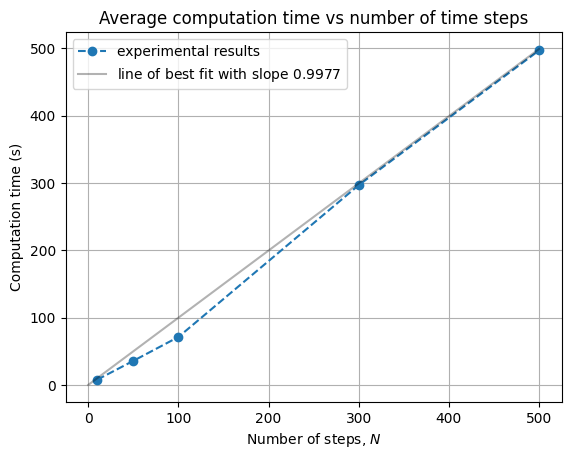

-1.4747434342650688e-06


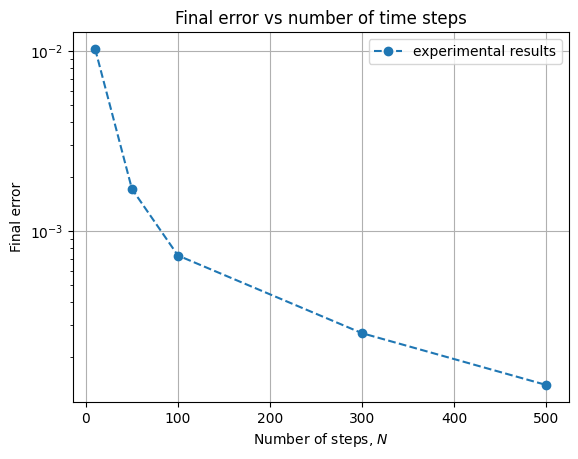

In [ ]:
avg_times = [np.mean(times[N]) for N in N_list]

plt.plot(N_list, avg_times, 'o--')
plt.plot(np.linspace(0,500,2), 0.9977262423476395*np.linspace(0,500,2), 'k-', alpha=0.3)
plt.xlabel('Number of steps, $N$')
plt.ylabel('Computation time (s)')
plt.title('Average computation time vs number of time steps')
plt.legend(['experimental results','line of best fit with slope $0.9977$'])
plt.grid()
plt.show()

avg_final_error = [avg_error[N][-1] for N in N_list]
m = (avg_final_error[-1] - avg_final_error[2])/(N_list[-1] - N_list[2])
plt.figure()
plt.plot(N_list, avg_final_error , 'o--')
plt.yscale('log')
plt.xlabel('Number of steps, $N$')
plt.ylabel('Final error')
plt.title('Final error vs number of time steps')
plt.legend(['experimental results','line of best fit with slope $-1.474 x 10^{-6}$'])
plt.grid()


(avg_times[-1] - avg_times[0])/(N_list[-1] - N_list[0])
print(m)